In [7]:
from mlagents_envs.envs.unity_gym_env import UnityToGymWrapper
from mlagents_envs.environment import ActionTuple, UnityEnvironment
from mlagents_envs.side_channel.engine_configuration_channel import \
    EngineConfigurationChannel
from mlagents_envs.exception import (
    UnityEnvironmentException,
    UnityCommunicationException,
    UnityCommunicatorStoppedException,
)
import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [49]:
import collections
from typing import Union
import math
import random
from copy import deepcopy
from typing import Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn.utils as nn_utils
from fastprogress import progress_bar as pb
import matplotlib.pyplot as plt

In [2]:
class ExpBuffer:

    def __init__(
        self,
        max_size: int = 1024,
        prob_alpha: float = 0.6,
        beta_start: float = 0.4,
        beta_frames: float = 100000,
        n_step: int = 4,
        gamma: float = 0.99,
    ):
        self._prob_alpha = prob_alpha
        self._max_size = max_size
        self._buf = []
        self._pos = 0
        self._beta_start = beta_start
        self._beta = beta_start
        self._beta_frames = beta_frames
        self._n_step = n_step
        self._gamma = gamma
        self._total_discounted_rewards = np.array([np.nan]*max_size)
        self._last_states = [np.nan]*max_size

    def update_bata(self, idx) -> None:
        beta = self._beta_start + idx * (1.0 - self._beta_start) / self._beta_frames
        self._beta = min(1.0, beta)
        return self._beta

    def __len__(self):
        return len(self._buf)

    def append(
        self,
        state: np.ndarray,
        action: int,
        reward: Union[int, float],
        done: bool,
        next_state: np.ndarray,
    ) -> None:
        if len(self._buf) < self._max_size:
            self._buf.append(
                (state, action, reward, done, next_state)
            )
        else:
            self._buf[self._pos] = (state, action, reward, done, next_state)

        if len(self._buf) >= self._n_step:
            dis_r = 0.0
            last_state = self._buf[self._pos][0]
            for i in range(self._n_step):
                state, _, r, done, _ = self._buf[self._pos - i]
                dis_r = r + self._gamma * dis_r
                if done:
                    last_state = state
                    dis_r = r  # ※
                self._total_discounted_rewards[self._pos - i] = dis_r
                self._last_states[self._pos - i] = last_state
            
            for i in range(self._n_step-1):
                done = self._buf[self._pos - i][3]
                if done:
                    break
                self._total_discounted_rewards[self._pos - i] = np.nan
                self._last_states[self._pos - i] = np.nan

        self._pos = (self._pos + 1) % self._max_size

    def get_latest_n(self, n: int):
        if len(self._buf) < self._max_size:
            if len(self._buf) < n+self._n_step:
                raise RuntimeError('get_latest_n : len(self._buf) < n+self._n_step')
            s_idx = self._pos - self._n_step - n 
            e_idx = self._pos - self._n_step
            latest_exps = self._buf[s_idx:e_idx]
            latest_total_rewards = self._total_discounted_rewards[s_idx:e_idx]
            latest_last_states = self._last_states[s_idx:e_idx]
        else:
            s_idx = self._pos + self._max_size - self._n_step - n
            e_idx = self._pos + self._max_size - self._n_step
            latest_exps = (self._buf*2)[s_idx:e_idx]
            latest_total_rewards = np.concatenate([self._total_discounted_rewards]*2)[s_idx:e_idx]
            latest_last_states = (self._last_states*2)[s_idx:e_idx]
        if len(latest_total_rewards) != n:
            print(f'{s_idx} : {e_idx} : {e_idx-s_idx} : {len((self._total_discounted_rewards*2))}')
        assert len(latest_exps) == n
        assert len(latest_total_rewards) == n
        assert len(latest_last_states) == n
        states, actions, rewards, dones, next_states = zip(*latest_exps)
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        dones = np.array(dones)
        next_states = np.array(next_states)
        last_states = np.stack(latest_last_states)
        return states, actions, rewards, dones, latest_total_rewards, last_states

    def update_priorities(self, sample_indices: np.ndarray, sample_priorities: np.ndarray) -> None:
        self._priorities[sample_indices] = sample_priorities

    @property
    def gamma(self) -> float:
        return self._gamma

    @property
    def n_step(self) -> float:
        return self._n_step

In [3]:
class NoisyLinear(nn.Linear):

    def __init__(self, in_features, out_features, sigma_init=0.017, bias=True):
        super(NoisyLinear, self).__init__(in_features, out_features, bias=bias)
        w = torch.full((out_features, in_features), sigma_init)
        self._sigma_weight = nn.Parameter(w)
        z = torch.zeros(out_features, in_features)
        self.register_buffer("epsilon_weight", z)
        if bias:
            w = torch.full((out_features,), sigma_init)
            self._sigma_bias = nn.Parameter(w)
            z = torch.zeros(out_features)
            self.register_buffer("epsilon_bias", z)
        self.reset_parameters()

    def reset_parameters(self):
        std = math.sqrt(3 / self.in_features)
        self.weight.data.uniform_(-std, std)
        self.bias.data.uniform_(-std, std)

    def forward(self, input):
        self.epsilon_weight.normal_()
        bias = self.bias
        if bias is not None:
            self.epsilon_bias.normal_()
            bias = bias + self._sigma_bias * \
                   self.epsilon_bias.data
        v = self._sigma_weight * self.epsilon_weight.data + \
            self.weight
        return F.linear(input, v, bias)

In [4]:
class A2C(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(A2C, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.policy = nn.Sequential(
            NoisyLinear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

        self.value = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        # x = x.float() / 256
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.policy(conv_out), self.value(conv_out)

In [92]:
class Agent:

    def __init__(
        self,
        env,
        exp_buffer: ExpBuffer,
        net: nn.Module,
        epsilon_start: float = 1.0,
        epsilon_final: float = 0.01,
        epsilon_decay_last_step: int = 200000,
        tgt_sync_steps: int = 10000,
        learning_rate: float = 1e-4,
        adam_eps: float = None,
        clip_grad: float = 0.1,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
        use_tgt_net: bool = False,
    ):
        self._env = env
        self._exp_buffer = exp_buffer
        self._net = net
        self._tgt_net = deepcopy(net)
        for p in self._tgt_net.parameters():
            p.requires_grad = False
        self._epsilon_start = epsilon_start
        self._epsilon_final = epsilon_final
        self._epsilon_decay_last_step = epsilon_decay_last_step
        self._epsilon = epsilon_start
        self._device = device
        self._total_step = 0
        self._total_trained_samples = 0
        self._clip_grad = clip_grad
        self._tgt_sync_steps = tgt_sync_steps
        adam_kwargs = {}
        if adam_eps is not None:
            adam_kwargs['eps'] = adam_eps
        self._optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, **adam_kwargs)
        self._reset_episode()
        self._use_tgt_net = use_tgt_net
        self._episode = 0
        self._episode_history = []
        self._print_episode_rewards = []

    def _reset_episode(self):
        self._state = self._env.reset()
        self._total_reward = 0.0

    @torch.no_grad()
    def play_step(self, epsilon: Optional[float] = None, sync_target: bool = True):
        if epsilon is None:
            epsilon = self._epsilon
        done_reward = None

        if np.random.random() < epsilon:
            action = self._env.action_space.sample()
        else:
            state_a = np.array([self._state], copy=False)
            state_v = torch.tensor(state_a).to(self._device)
            logits_v, value_v = self._net(state_v)
            # _, act_v = torch.max(logits_v, dim=1)
            # action = int(act_v.item())
            probs_v = F.softmax(logits_v, dim=1)
            prob = probs_v.data.cpu().numpy()[0]
            action = np.random.choice(len(prob), p=prob)

        next_state, reward, is_done, _ = self._env.step(action)
        self._total_reward += reward

        self._exp_buffer.append(
            self._state, action, reward, is_done, next_state
        )
        self._state = next_state
        if is_done:
            done_reward = self._total_reward
            self._reset_episode()

        self._total_step += 1
        self._update_epsilon(self._total_step)
        self._exp_buffer.update_bata(self._total_step)

        if self._total_step % self._tgt_sync_steps == 0 and sync_target and self._use_tgt_net:
            self._tgt_net.load_state_dict(self._net.state_dict())
            print(f'synced target net')

        return done_reward

    def train(self, n_iter: int = 1, batch_size: int = 32, print_episode_steps: int = 1) -> None:
        n_step_gamma = self._exp_buffer.gamma ** self._exp_buffer.n_step
        for i in range(n_iter):
            for s in range(batch_size):
                done_reward = self.play_step()
                if done_reward is not None:
                    self._print_episode_rewards.append(done_reward)
                    if self._episode % print_episode_steps == 0:
                        drm = sum(self._print_episode_rewards) / len(self._print_episode_rewards)
                        print(f'episode : {self._episode}, done reward mean : {drm}, total_step : {self._total_step}, cur_epsilon : {self._epsilon}')
                        self._print_episode_rewards.clear()
                    self._episode_history.append((self._episode, done_reward, self._total_step, self._epsilon))
                    self._episode += 1
            states, actions, rewards, dones, total_discounted_rewards, \
                last_states = self._exp_buffer.get_latest_n(batch_size)
            states_v = torch.tensor(states).to(self._device)
            actions_v = torch.tensor(actions).to(self._device)
            discounted_rewards_v = torch.tensor(total_discounted_rewards).to(self._device)
            done_mask = torch.BoolTensor(dones).to(self._device)
            # weights_v = torch.tensor(weights).to(self._device)

            with torch.no_grad():
                last_states_v = torch.tensor(last_states).to(self._device)
                if self._use_tgt_net:
                    last_state_values = self._tgt_net(last_states_v)[1].squeeze(-1)
                else:
                    last_state_values = self._net(last_states_v)[1].squeeze(-1)
                last_state_values[done_mask] = 0.0
                # print(f'[1] {last_state_values.shape} : {discounted_rewards_v.shape}')
                expected_state_values = last_state_values.detach() * n_step_gamma + discounted_rewards_v

            self._optimizer.zero_grad()
            logits_v, value_v = self._net(states_v)
            # print(f'[2] {value_v.shape} : {expected_state_values.shape}')
            loss_value_v = F.mse_loss(expected_state_values.float(), value_v.squeeze(-1).float())  # (R(s,a) - V(s))^2

            log_prob_v = F.log_softmax(logits_v, dim=1)
            adv_v = expected_state_values - value_v.detach()  # A(s, a) = R(s,a) - V(s)
            log_prob_actions_v = adv_v * log_prob_v[range(batch_size), actions_v]
            # log_prob_actions_v *= weights_v
            loss_policy_v = -log_prob_actions_v.mean()

            prob_v = F.softmax(logits_v, dim=1)
            entropy_loss_v = batch_size * (prob_v * log_prob_v).sum(dim=1).mean()

            loss_policy_v.backward(retain_graph=True)
            grads = np.concatenate([p.grad.data.cpu().numpy().flatten()
                                    for p in self._net.parameters()
                                    if p.grad is not None])

            loss_v = entropy_loss_v + loss_value_v
            loss_v.backward()
            nn_utils.clip_grad_norm_(self._net.parameters(), self._clip_grad)
            self._optimizer.step()

            loss_v += loss_policy_v

            # self._exp_buffer.update_priorities(sampled_indices, prios)  # 不要?
            self._total_trained_samples += batch_size

    def initial_exploration(self, n_steps: int = 10000, epsilon: float = 1.0) -> None:
        eps_bak = self._epsilon
        for i in pb(range(n_steps)):
            self._epsilon = epsilon
            self.play_step(sync_target=False)
        self._total_step = 0
        self._epsilon = eps_bak

    def _update_epsilon(self, step_index: int) -> None:
        self._epsilon = max(
            self._epsilon_final,
            self._epsilon_start - step_index / self._epsilon_decay_last_step
        )

In [8]:
class UnityToGymNumpyImgWrapper(UnityToGymWrapper):
    def __init__(self, *args, **kwargs):
        super(UnityToGymNumpyImgWrapper, self).__init__(*args, **kwargs)

    def reset(self, *args, **kwargs):
        state = super().reset(*args, **kwargs)
        return np.array(state[0]).transpose(2, 0, 1)

    def step(self, *args, **kwargs):
        next_state, reward, is_done, info = super().step(*args, **kwargs)
        return np.array(next_state[0]).transpose(2, 0, 1), reward, is_done, info

In [9]:
class UnityToGymNumpyImgResizeWrapper(UnityToGymNumpyImgWrapper):
    def __init__(self, *args, **kwargs):
        super(UnityToGymNumpyImgResizeWrapper, self).__init__(*args, **kwargs)

    def reset(self, *args, **kwargs):
        state = super().reset(*args, **kwargs)
#         return cv2.resize(state[:, :, 10:-10].transpose(1, 2, 0), (224, 224)).transpose(2, 0, 1)
        return state[:, :, 10:-10]

    def step(self, *args, **kwargs):
        next_state, reward, is_done, info = super().step(*args, **kwargs)
        next_state = cv2.resize(next_state[:, :, 10:-10].transpose(1, 2, 0), (224, 224)).transpose(2, 0, 1)
#         return next_state, reward, is_done, info
        return next_state[:, :, 10:-10], reward, is_done, info

In [10]:
class UnityToGymNumpyImgResizeGrayWrapper(UnityToGymNumpyImgWrapper):
    def __init__(self, *args, **kwargs):
        super(UnityToGymNumpyImgResizeGrayWrapper, self).__init__(*args, **kwargs)

    def reset(self, *args, **kwargs):
        state = super().reset(*args, **kwargs)
        return cv2.cvtColor(state[:, :, 10:-10].transpose(1, 2, 0), cv2.COLOR_RGB2GRAY).reshape(1, 64, 64)
#         return state[:, :, 10:-10]

    def step(self, *args, **kwargs):
        next_state, reward, is_done, info = super().step(*args, **kwargs)
        next_state = cv2.cvtColor(next_state[:, :, 10:-10].transpose(1, 2, 0), cv2.COLOR_RGB2GRAY).reshape(1, 64, 64)
#         return next_state, reward, is_done, info
        return next_state, reward, is_done, info

In [11]:
try:
    unity_env.close()
except Exception:
    pass

In [12]:
unity_env = UnityEnvironment(file_name=None)

In [13]:
unity_env.reset()

In [14]:
# env = UnityToGymWrapper(unity_env, allow_multiple_obs=True)
env = UnityToGymNumpyImgResizeGrayWrapper(unity_env, allow_multiple_obs=True)

In [15]:
# Unity環境のリセット
unity_env.reset()

# BehaviorNameのリストの取得
behavior_names = list(unity_env.behavior_specs.keys())
print('behavior_names:', behavior_names)

# BehaviorSpecの取得
behavior_spec = unity_env.behavior_specs[behavior_names[0]]

# BehaviorSpecの情報の確認
print('\n== BehaviorSpecの情報の確認 ==')
print('observation_specs:', behavior_spec.observation_specs)
print('action_spec:', behavior_spec.action_spec)

behavior_names: ['GridWorld?team=0']

== BehaviorSpecの情報の確認 ==
observation_specs: [ObservationSpec(shape=(64, 84, 3), dimension_property=(<DimensionProperty.TRANSLATIONAL_EQUIVARIANCE: 2>, <DimensionProperty.TRANSLATIONAL_EQUIVARIANCE: 2>, <DimensionProperty.NONE: 1>), observation_type=<ObservationType.DEFAULT: 0>, name='CameraSensor'), ObservationSpec(shape=(2,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.GOAL_SIGNAL: 1>, name='VectorSensor')]
action_spec: Continuous: 0, Discrete: (5,)


In [16]:
behavior_spec

BehaviorSpec(observation_specs=[ObservationSpec(shape=(64, 84, 3), dimension_property=(<DimensionProperty.TRANSLATIONAL_EQUIVARIANCE: 2>, <DimensionProperty.TRANSLATIONAL_EQUIVARIANCE: 2>, <DimensionProperty.NONE: 1>), observation_type=<ObservationType.DEFAULT: 0>, name='CameraSensor'), ObservationSpec(shape=(2,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.GOAL_SIGNAL: 1>, name='VectorSensor')], action_spec=ActionSpec(continuous_size=0, discrete_branches=(5,)))

In [17]:
# 現在のステップの情報の取得
decision_steps, terminal_steps = unity_env.get_steps(behavior_names[0])

# DecisionStepsの情報の確認
print('\n== DecisionStepsの情報の確認 ==')
print('obj:', decision_steps.obs)
print('reward:', decision_steps.reward)
print('agent_id:', decision_steps.agent_id)
print('action_mask:', decision_steps.action_mask)

# TerminalStepsの情報の確認
print('\n== TerminalStepsの情報の確認 ==')
print('obs:', terminal_steps.obs)
print('reward:', terminal_steps.reward)
print('agent_id:', terminal_steps.agent_id)
print('interrupted:', terminal_steps.interrupted)


== DecisionStepsの情報の確認 ==
obj: [array([[[[0.5372549 , 0.54901963, 0.56078434],
         [0.5372549 , 0.54901963, 0.56078434],
         [0.5372549 , 0.54901963, 0.56078434],
         ...,
         [0.5372549 , 0.54509807, 0.56078434],
         [0.5372549 , 0.54509807, 0.56078434],
         [0.5372549 , 0.54509807, 0.56078434]],

        [[0.5372549 , 0.54901963, 0.56078434],
         [0.5372549 , 0.54901963, 0.56078434],
         [0.5372549 , 0.54901963, 0.56078434],
         ...,
         [0.5372549 , 0.54509807, 0.56078434],
         [0.5372549 , 0.54509807, 0.56078434],
         [0.5372549 , 0.54509807, 0.56078434]],

        [[0.5372549 , 0.54901963, 0.56078434],
         [0.5372549 , 0.54901963, 0.56078434],
         [0.5372549 , 0.54509807, 0.56078434],
         ...,
         [0.5372549 , 0.54509807, 0.56078434],
         [0.5372549 , 0.54509807, 0.56078434],
         [0.5372549 , 0.54509807, 0.56078434]],

        ...,

        [[0.5372549 , 0.54509807, 0.56078434],
         [0.

In [18]:
len(decision_steps.obs)

2

In [19]:
decision_steps.obs[1].shape

(1, 2)

In [20]:
decision_steps.obs[0].shape

(1, 64, 84, 3)

In [21]:
N_AGENTS = decision_steps.obs[0].shape[0]

In [22]:
N_AGENTS

1

In [23]:
N_ACTIONS = behavior_spec.action_spec.discrete_branches[0]

In [24]:
N_ACTIONS

5

In [25]:
env.action_space

Discrete(5)

In [26]:
env.action_space.sample()

1

In [27]:
env.observation_space

Tuple(Box(0.0, 1.0, (64, 84, 3), float32), Box(-inf, inf, (2,), float32))

In [28]:
state = env.reset()

In [29]:
state.shape

(1, 64, 64)

In [30]:
OBS_DIM = state.shape

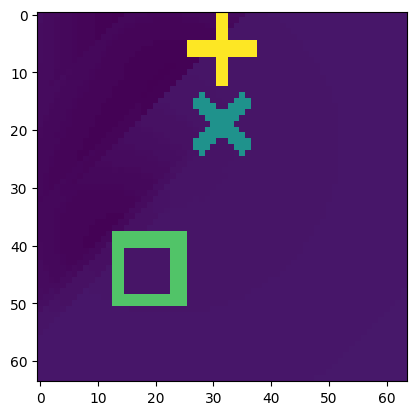

In [31]:
plt.imshow(state.transpose(1, 2, 0))

In [32]:
torch.tensor(np.array(state)).unsqueeze(0).shape

torch.Size([1, 1, 64, 64])

In [33]:
next_state, reward, is_done, _ = env.step(env.action_space.sample())

In [34]:
next_state.shape

(1, 64, 64)

In [35]:
reward

-0.01

In [36]:
is_done

False

In [37]:
env.action_size

1

In [93]:
SEED = 77

In [94]:
random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [95]:
net = A2C(input_shape=OBS_DIM, n_actions=N_ACTIONS).to(device)

In [96]:
net(torch.tensor(state).unsqueeze(0).to(device))

(tensor([[ 0.0285, -0.0030, -0.0026, -0.0016, -0.0351]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 tensor([[0.0139]], device='cuda:0', grad_fn=<AddmmBackward0>))

In [97]:
exp_buffer = ExpBuffer(
    # max_size=1024,
    prob_alpha=0.6,
    beta_start=0.4,
    beta_frames=30000, #100000,
    n_step=4,
    gamma=0.99,
)

In [98]:
agent = Agent(
    env=env,
    exp_buffer=exp_buffer,
    net=net,
    epsilon_start=0.0,
    epsilon_final=0.0,
    epsilon_decay_last_step=30000, #200000,
    tgt_sync_steps=1000,
    learning_rate=5e-4,
    adam_eps=1e-3,
    device=device
)

In [99]:
agent.initial_exploration(n_steps=100)

In [100]:
states, actions, rewards, dones, next_states = zip(*agent._exp_buffer._buf)

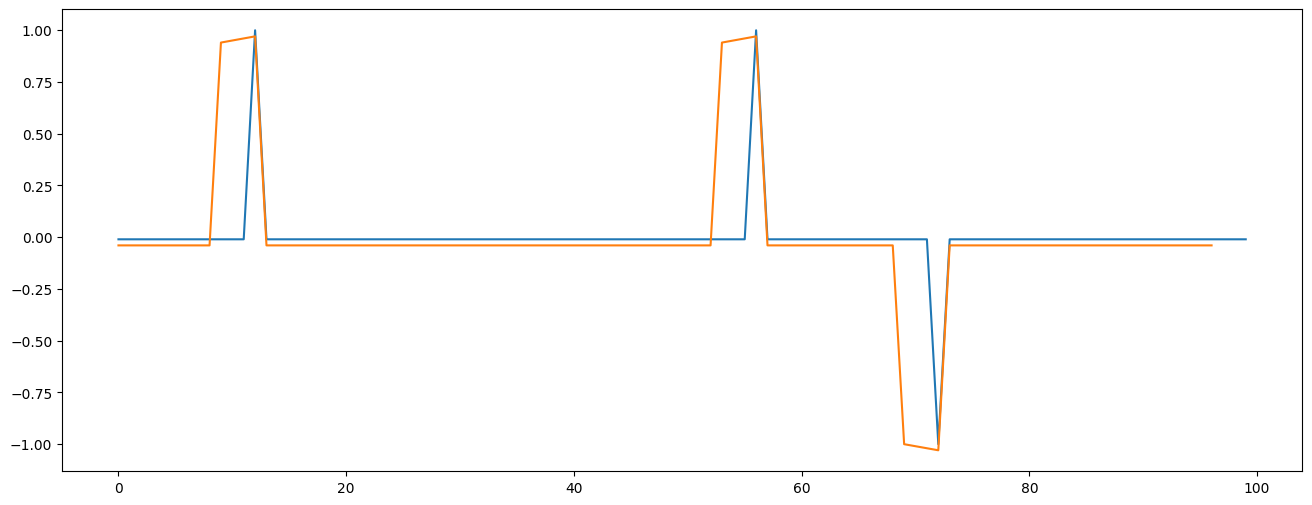

In [101]:
plt.figure(figsize=(16, 6))
plt.plot(rewards[:200])
plt.plot(agent._exp_buffer._total_discounted_rewards[:200])

In [102]:
# exp_buffer = ExpBuffer(
#     # max_size=1024,
#     prob_alpha=0.6,
#     beta_start=0.4,
#     beta_frames=30000, #100000,
#     n_step=4,
#     gamma=0.99,
# )
# agent = Agent(
#     env=env,
#     exp_buffer=exp_buffer,
#     net=net,
#     epsilon_start=0.0,
#     epsilon_final=0.0,
#     epsilon_decay_last_step=30000, #200000,
#     tgt_sync_steps=1000,
#     learning_rate=5e-4,
#     adam_eps=1e-3,
#     device=device
# )

episode = 0

while True:
    agent.train(n_iter=20, batch_size=32, print_episode_steps=100)

episode : 0, done reward mean : 0.3800000138580799, total_step : 36, cur_epsilon : 0.0
episode : 100, done reward mean : -0.12889999331906438, total_step : 3118, cur_epsilon : 0.0
episode : 200, done reward mean : -0.15879999443888665, total_step : 5703, cur_epsilon : 0.0
episode : 300, done reward mean : -0.2806999928317964, total_step : 9000, cur_epsilon : 0.0
episode : 400, done reward mean : -0.589499994199723, total_step : 11694, cur_epsilon : 0.0
episode : 500, done reward mean : -0.34429999297484754, total_step : 14930, cur_epsilon : 0.0
episode : 600, done reward mean : -0.2590999944321811, total_step : 17516, cur_epsilon : 0.0
episode : 700, done reward mean : -0.14649999359622598, total_step : 20477, cur_epsilon : 0.0
episode : 800, done reward mean : -0.414999993853271, total_step : 23325, cur_epsilon : 0.0
episode : 900, done reward mean : -0.41319999389350415, total_step : 26151, cur_epsilon : 0.0
episode : 1000, done reward mean : -0.4460999924875796, total_step : 29601, 

KeyboardInterrupt: 

In [103]:
env.close()

In [ ]:
    # // to be implemented by the developer
    # public override void OnEpisodeBegin()
    # {
    #     area.AreaReset();
    #     Array values = Enum.GetValues(typeof(GridGoal));
    #     // if (m_GoalSensor is object)
    #     // {
    #     //     CurrentGoal = (GridGoal)values.GetValue(UnityEngine.Random.Range(0, values.Length));
    #     // }
    #     // else
    #     // {
    #     //     CurrentGoal = GridGoal.GreenPlus;
    #     // }
    #     CurrentGoal = GridGoal.GreenPlus;
    # }